SCENARIO ANALYSES

BIOMASS PRODUCED AT PSO4,max PERTURBATION

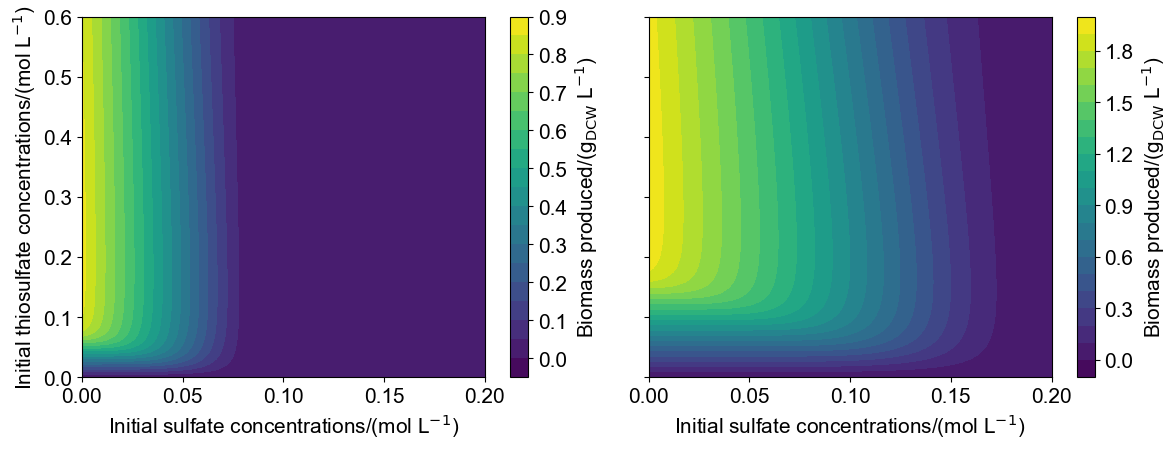

In [1]:
# ========= SCENARIO ANALYSIS: BIOMASS PRODUCED AT PSO4,max PERTURBATION =========

# -------- Import Libraries --------
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ===================== MODEL AND KINETIC CALIBRATION PARAMETERS =====================
u, Ks, Ki, Pso4_max, ms, k_so = 0.4956, 0.08788, 0.2196, 0.1258, 1e-05, 1e-05
k = 1.6
Yxs = 11.6
Yps = 1.16
Yp2s = 0.7
Ks_switch = 0.010
Yso4_s0 = 0.00000

# ===================== MODEL DEFINITION =====================
def model(y, t, u, Ks, Ki, Pso4_max, ms, k_so, k):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** k)  # Eq. 10
    dXdt = mu * X                                                                   # Eq. 6
    r_so = k_so * Ps * X if S < Ks_switch else 0                                    # Eq. 17
    dSdt = (dXdt * (-1 / Yxs)) - ms * X                                             # Eq. 14
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so                                      # Eq. 15
    dP2dt = dXdt * (Yp2s / Yxs) - r_so                                              # Eq. 16
    return [dXdt, dSdt, dPdt, dP2dt]

# ===================== STATE VARIABLE RANGES AND SWEEP SETTINGS =====================
S_sweep = np.linspace(0.00, 0.600, 100)         # Initial thiosulfate, change as needed
P_sweep = np.linspace(0.00, 0.200, 100)         # Initial sulfate, change as needed
X0 = 0.1                                        # Initial biomass, change as needed
PS0 = 0.01                                      # Initial elemental sulfur, change as needed
t_points = np.array([0.00, 20.58, 45.02, 68.72, 95.80])

# -------- NOTE: 'Pso4max_vals' can be adapted to sweep any model parameter (e.g., k, Ki, etc.) --------
Pso4max_vals = [
    Pso4_max * 0.7,    # -30% perturbation (adapt as needed)
    Pso4_max * 1.6     # +60% perturbation (adapt as needed)
]

plot_labels = ['-30%', '+60%']

plt.rcParams['font.family'] = 'Arial'
all_heatmaps = []

# ===================== SCENARIO SIMULATION LOOP =====================
for Pmax in Pso4max_vals:
    biomass_produced = np.zeros((len(S_sweep), len(P_sweep)))
    for i, S0 in enumerate(S_sweep):
        for j, P0 in enumerate(P_sweep):
            y0 = [X0, S0, P0, PS0]
            sol = odeint(model, y0, t_points, args=(u, Ks, Ki, Pmax, ms, k_so, k))
            Xf, Sf, Pf, PSf = sol[-1]  # Final state values
            # -------- NOTE: The output here is 'net biomass produced'. 
            # Adapt this calculation for other outputs, e.g.:
            #   - Substrate consumed:   S0 - Sf
            #   - Sulfate produced:     Pf - P0
            #   - Elemental S produced: PSf - PS0
            # Just update the line below as needed.
            biomass_produced[i, j] = Xf - X0  # Net biomass produced

    all_heatmaps.append(biomass_produced)


# ===================== PLOTTING: SCENARIO HEATMAPS =====================
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, heatmap, label in zip(axs, all_heatmaps, plot_labels):      # Change plot type as needed
    im = ax.contourf(P_sweep, S_sweep, heatmap, levels=20, cmap='viridis')
    ax.set_xlabel('Initial sulfate concentrations/(mol L$^{-1}$)', fontsize=15)
    if label == '-30%':
        ax.set_ylabel('Initial thiosulfate concentrations/(mol L$^{-1}$)', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r'Biomass produced/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
    cbar.ax.tick_params(labelsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
